In [4]:
import numpy as np
import pandas as pd
from sodapy import Socrata

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
import re

## Project Ideas

* Given the Geodata, date, time, -- How likely the complaint to be of a certain category?
Purpose: Help government to allocate resources efficiently 

* Which depertments are most efficient with responding to service requests
* Where the complaints are coming from, when and from whom?

## Data

In [57]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# link https://dev.socrata.com/foundry/data.cityofnewyork.us/fhrw-4uyv
# tatal record = 9362925
results = client.get("fhrw-4uyv", limit=93629)

# Convert to pandas DataFrame
data = pd.DataFrame.from_records(results)

In [79]:
total_record = 9362925
selected_record = 93629
selected_record/total_record*100

0.9999973298942372

### Datatypes

In [61]:
date_cols = ['closed_date', 'created_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])

In [85]:
data[['unique_key', 'agency', 'complaint_type', 'status',
      'closed_date', 'created_date', 'due_date']].to_pickle('Data/timedelta_study.pkl')

#### Parse data and time

In [ ]:
data['closed_date_year'] = data['closed_date'].dt.year
data['closed_date_month'] = data['closed_date'].dt.month
data['closed_date_dayofmonth'] = data['closed_date'].dt.day
data['closed_date_dayofweek'] = data['closed_date'].dt.dayofweek
data['closed_date_hour'] = data['closed_date'].dt.hour

data['created_date_year'] = data['created_date'].dt.year
data['created_date_month'] = data['created_date'].dt.month
data['created_date_dayofmonth'] = data['created_date'].dt.day
data['created_date_dayofweek'] = data['created_date'].dt.dayofweek
data['created_date_hour'] = data['created_date'].dt.hour

data['due_date_year'] = data['due_date'].dt.year
data['due_date_month'] = data['due_date'].dt.month
data['due_date_dayofmonth'] = data['due_date'].dt.day
data['due_date_dayofweek'] = data['due_date'].dt.dayofweek
data['due_date_hour'] = data['due_date'].dt.hour

In [81]:
data['response_time'] = (data['closed_date'] - data['created_date']) / dt.timedelta(minutes=1)
data['remaining_time'] = (data['due_date'] - data['closed_date']) / dt.timedelta(minutes=1)


In [80]:
data.status.value_counts()

Closed      89470
Pending      2181
Assigned     1065
Open          876
Started        36
Name: status, dtype: int64

In [ ]:
from sklearn.preprocessing import MinMaxScaler


### Missing Values

In [19]:
data.isnull().sum()/len(data)*100

address_type                       0.260603
agency                             0.000000
agency_name                        0.000000
bbl                               16.309050
borough                            0.000000
bridge_highway_direction          99.831249
bridge_highway_name               99.831249
bridge_highway_segment            99.831249
city                               0.007476
closed_date                        2.195901
community_board                    0.000000
complaint_type                     0.000000
created_date                       0.000000
cross_street_1                    52.867167
cross_street_2                    52.968632
descriptor                         0.000000
due_date                          61.070822
facility_type                      0.001068
incident_address                  12.158626
incident_zip                       0.017089
intersection_street_1             87.596792
intersection_street_2             87.596792
landmark                        

Text(0.5,1,'% of NaN values by agency')

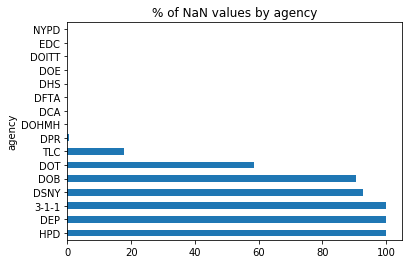

In [115]:
# Null due date by agency
d = (data[data.due_date.isnull()].groupby(['agency']).unique_key.count()/data.groupby(['agency']).unique_key.count()*100)
# d = d.unstack
d.sort_values(ascending=False).plot(kind='barh')
plt.title("% of NaN values by agency")

## Evaluating Features

#### Address Type

In [91]:
data.address_type.unique()

array(['ADDRESS', 'BLOCKFACE', 'INTERSECTION', 'LATLONG', nan, 'PLACENAME'], dtype=object)

Text(0.5,1,'Complaint Counts by Address Types')

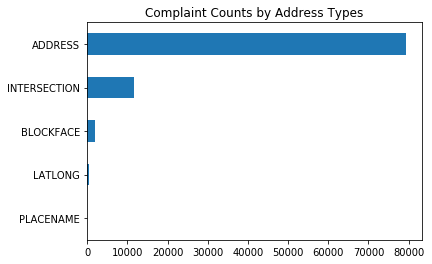

In [116]:
data.address_type.value_counts(ascending=True).plot(kind='barh')
plt.title("Complaint Counts by Address Types")

#### Agency

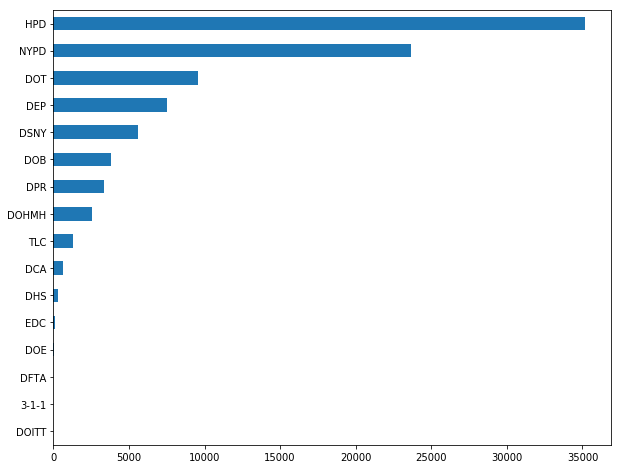

In [110]:
data.agency.value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10,8))

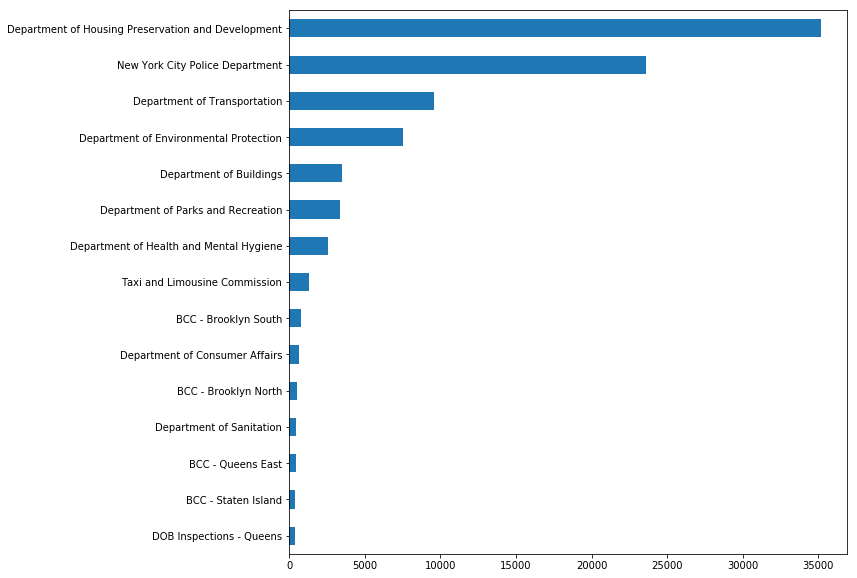

In [133]:
data.agency_name.value_counts().head(15).sort_values(ascending=True).plot(kind='barh', figsize=(10,10))

In [86]:
data.columns

Index(['address_type', 'agency', 'agency_name', 'bbl', 'borough',
       'bridge_highway_direction', 'bridge_highway_name',
       'bridge_highway_segment', 'city', 'closed_date', 'community_board',
       'complaint_type', 'created_date', 'cross_street_1', 'cross_street_2',
       'descriptor', 'due_date', 'facility_type', 'incident_address',
       'incident_zip', 'intersection_street_1', 'intersection_street_2',
       'landmark', 'latitude', 'location', 'location_type', 'longitude',
       'open_data_channel_type', 'park_borough', 'park_facility_name',
       'resolution_action_updated_date', 'resolution_description', 'road_ramp',
       'status', 'street_name', 'taxi_company_borough',
       'taxi_pick_up_location', 'unique_key', 'vehicle_type',
       'x_coordinate_state_plane', 'y_coordinate_state_plane', 'response_time',
       'remaining_time'],
      dtype='object')

#### Complaint Types

In [5]:
top_complaints = data.complaint_type.value_counts()[
    data.complaint_type.value_counts()>data.complaint_type.value_counts().mean()]

Text(0.5,1,'Top Complaints')

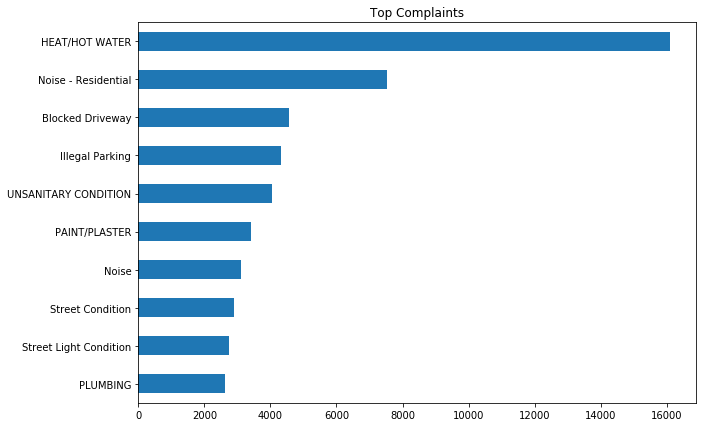

In [117]:
top_complaints.head(10).sort_values(ascending=True).plot(kind='barh', figsize=(10,7))
plt.title("Top Complaints")

In [125]:
data[['agency_name', 'agency']].drop_duplicates()

,agency_name,agency
0,New York City Police Department,NYPD
11,BCC - Brooklyn North,DSNY
12,Department of Environmental Protection,DEP
18,BCC - Brooklyn South,DSNY
34,Department of Health and Mental Hygiene,DOHMH
48,Department of Parks and Recreation,DPR
56,BCC - Bronx,DSNY
65,Department of Transportation,DOT
71,Department of Housing Preservation and Develop...,HPD
72,Taxi and Limousine Commission,TLC


for i, col in enumerate(data.columns):
    print(i, col)

## ML Prep

In [1]:
model_feature = ['borough', 'city', 'created_date',
       'incident_zip', 'latitude', 'longitude', 'complaint_type']

In [2]:
mdata = data[model_feature]
mdata = mdata.dropna()
mdata.isnull().sum()

NameError: name 'data' is not defined

In [5]:
client = Socrata("data.cityofnewyork.us", None)

# link https://dev.socrata.com/foundry/data.cityofnewyork.us/fhrw-4uyv
# tatal record = 9362925
results = client.get("fhrw-4uyv", limit=93629, select='agency')

# Convert to pandas DataFrame
d = pd.DataFrame.from_records(results)

In [6]:
client = Socrata("data.cityofnewyork.us", None)
df = pd.DataFrame()

for col in model_feature:
    results = client.get("fhrw-4uyv", limit=93629, select=col)
    d = pd.DataFrame.from_records(results)
    df = pd.concat([df, d], axis=1)

In [7]:
df.head()

,borough,city,created_date,incident_zip,latitude,longitude,complaint_type
0,BRONX,.,2010-01-01T00:24:00.000,--------,39.5525551788817,-78.18450807772693,Adopt-A-Basket
1,BRONX,.,2010-01-01T00:54:00.000,?,39.5525551788817,-78.18450807772693,Adopt-A-Basket
2,BRONX,.,2010-01-01T01:00:00.000,?,39.5525551788817,-78.18450807772693,Adopt-A-Basket
3,BRONX,*,2010-01-01T01:00:00.000,?,40.49804421521046,-74.25521082506387,Adopt-A-Basket
4,BRONX,*,2010-01-01T01:07:00.000,.,40.49862773316935,-74.25521082506387,Adopt-A-Basket


In [8]:
zipcodes = []
with open('Data/NYCzipcodes_raw.txt') as file:
    zipcodes_raw = file.read()
for i, z in enumerate(zipcodes_raw.split()):
    if i%2==0:
        zipcodes.append(z)

In [193]:
# data['match'] = data['match'].apply(lambda x:1 if x==True else 0)
df['incident_zip'].apply(lambda x: x[:6] if x[:6] in zipcodes else 0)

#re.search('([0-9]+)-[0-9]', movie).group(1)

0            0
1            0
2            0
3            0
4            0
5            0
6            0
7            0
8            0
9            0
10           0
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           0
22           0
23           0
24           0
25           0
26           0
27           0
28           0
29           0
         ...  
93599    10002
93600    10002
93601    10002
93602    10002
93603    10002
93604    10002
93605    10002
93606    10002
93607    10002
93608    10002
93609    10002
93610    10002
93611    10002
93612    10002
93613    10002
93614    10002
93615    10002
93616    10002
93617    10002
93618    10002
93619    10002
93620    10002
93621    10002
93622    10002
93623    10002
93624    10002
93625    10002
93626    10002
93627    10002
93628    10002
Name: incident_zip, Length: 93629, dtype: object

In [183]:
df.incident_zip.value_counts()

10001    48615
10002    42097
0         2917
Name: incident_zip, dtype: int64

In [198]:
df.incident_zip.value_counts()/len(df)*100

10001         51.923015
10002         44.961497
10000          0.666460
07114          0.660052
00083          0.387700
00000          0.140982
0              0.124961
07030          0.072627
07302          0.061947
07310          0.051266
07047          0.034177
07086          0.033109
07306          0.033109
07094          0.032041
07024          0.025633
07087          0.021361
07020          0.020293
000000         0.019225
07093          0.019225
07304          0.018157
07073          0.017089
07054          0.017089
07102          0.016021
07305          0.012817
07666          0.012817
06901          0.011748
07601          0.009612
07307          0.009612
08003          0.008544
07410          0.008544
                ...    
06810          0.001068
00116          0.001068
02250-5126     0.001068
02907          0.001068
08820          0.001068
07624          0.001068
07458          0.001068
07011          0.001068
07032          0.001068
07123          0.001068
0714           0

In [9]:
df.city.unique()

array(['.', '*', '0', '00', '000', '0000', '1', '#200 BREA', 'A', '/A',
       'ABERDEEN', 'ADDISON', 'AGUSTA', 'AL', 'ALANTA', 'ALBANY',
       'ALBERTSON', 'ALLENTOWN', 'ALPHARATTA', 'ALPHARETTA', 'ALPINE',
       'ALTON', 'AMHERST', 'AMITYVILLE', 'AMNETYVILLE', 'AMYTVILLE',
       'ANDREWS', 'ANON', 'ANONYMOUS', 'ANTIONO', 'ARCADE', 'ARDSLEY',
       'ARMANK', 'ARMONK', 'Arverne', 'ARVERNE', 'ASBURY PARK', 'Astoria',
       'ASTORIA'], dtype=object)

In [ ]:
df.longitude

In [10]:
df.dtypes

borough           object
city              object
created_date      object
incident_zip      object
latitude          object
longitude         object
complaint_type    object
dtype: object

Lots of cleaning needed. Decided to use 2015 data for the study due to limited time. requires less cleaning